# jaxsnn

[jaxsnn](https://github.com/electronicvisions/jaxsnn) is an event-based training framework for spiking neural networks (SNNs) implemented in JAX. It provides support for numerical model simulation.

Training of SNNs is done in the init/apply style, where an `init` function contains the initial parameters and the `apply` function represents the forward pass as well as the backward pass through the SNN.

### Export a NIR graph from NIR to jaxsnn

In [ ]:
from jax import random
import jaxsnn
import nir
import numpy as np

input_size = 3
output_size = 2

np_rng = np.random.default_rng(42)
weight = np_rng.uniform(low=0.5, high=1.5, size=(output_size, input_size))

# Create a simple NIR graph
nir_model = nir.NIRGraph(
    nodes={
        "input": nir.Input(input_type=np.array([input_size])),
        "linear": nir.Linear(weight=weight),
        "cubalif": nir.CubaLIF(
            tau_mem=np.array([4e-4]*output_size),
            tau_syn=np.array([2e-4]*output_size),
            r=np.array([1]*output_size),
            v_leak=np.array([0]*output_size),
            v_reset=np.array([-1]*output_size),
            v_threshold=np.array([1]*output_size),
        ),
        "output": nir.Output(output_type=np.array([output_size])),
    },
    edges=[("input", "linear"), ("linear", "cubalif"), ("cubalif", "output")],
)

# Convert to jaxsnn
config = jaxsnn.ConversionConfig(t_max = 4*2e-4,
                                 n_spikes = {"cubalif": 20})
init, apply = jaxsnn.from_nir(nir_model, config)

Note that here, the `apply` function performs the forward pass as well as the backward pass (pure simulator).
It is also possible to perform the forward pass externally, e.g. on a [BrainScaleS-2](https://open-neuromorphic.org/neuromorphic-computing/hardware/brainscales-2-universitat-heidelberg/) chip or other neuromorphic hardware and use jaxsnn only for gradient computation on the external spike times. This needs to be specified by the `external` argument in the `ConversionConfig` object.

### Test the network with some input spikes

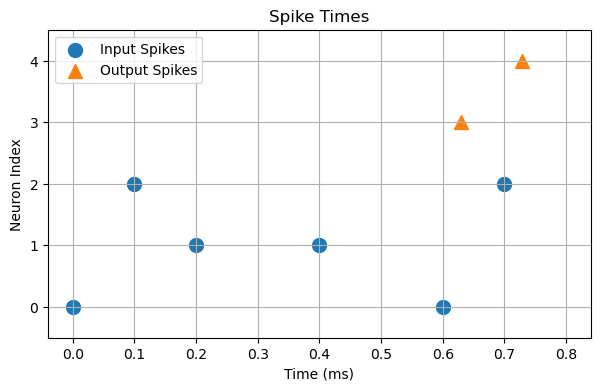

In [4]:
import jax.numpy as jnp
from jaxsnn.event.types import EventPropSpike
import matplotlib.pyplot as plt

rng = random.PRNGKey(42)

# Create input spikes
input_spikes = EventPropSpike(
    time=jnp.array([0.0, 1e-4, 2e-4, 4e-4, 6e-4, 7e-4]),
    idx=jnp.array([0, 2, 1, 1, 0, 2]),
    current=jnp.array([0.0, 0.0, 0.0, 0.0, 0.0]))

# Apply the model
_, weight = init(rng, 1)
_, _, output, _ = apply(weight, input_spikes)

# Plot spike times
is_input = output.idx < input_size  # Input neurons are indexed 0, 1 and 2
is_output = output.idx >= input_size  # Output neurons are indexed 3 and 4

plt.figure(figsize=(7, 4))
plt.scatter(output.time[is_input]*1000, output.idx[is_input], marker='o',
            label='Input Spikes', s=100)
plt.scatter(output.time[is_output]*1000, output.idx[is_output], marker='^',
            label='Output Spikes', s=100)
plt.title("Spike Times")
plt.xlabel("Time (ms)")
plt.ylabel("Neuron Index")
plt.ylim(-0.5, 4.5)  # Adjust x-axis limits based on t_max
plt.grid()
plt.legend()
plt.show()
